JetNet_Configs(data_dir='../../data/jetnet', data_name='JetNet30', features=['eta_rel', 'phi_rel', 'pt_rel'], dim_input=3, num_particles=30, jet_types='t', preprocess=['standardize'])
+------------+-------------------------------------------------+
| Parameters | Values                                          |
+------------+-------------------------------------------------+
| mean       | tensor([-9.1263e-06, -4.9133e-05,  3.0458e-02]) |
| std        | tensor([0.1158, 0.1166, 0.0395])                |
+------------+-------------------------------------------------+


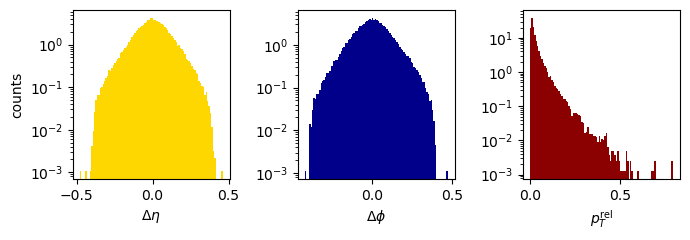

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from DynGenModels.datamodules.jetnet.datasets import JetNetDataset
from DynGenModels.datamodules.jetnet.configs import JetNet_Configs
from DynGenModels.utils.utils import print_table

configs = JetNet_Configs(data_dir="../../data/jetnet", jet_types="t")
print(configs)
tops = JetNetDataset(configs)

def feature_plots(jetnet_data, generated=None, save_dir=None, features=[r'$\Delta\eta$', r'$\Delta\phi$', r'$p^{\rm rel}_T$'], num_particles=100000, color='blue'):
    _, axs = plt.subplots(1, 3, figsize=(7, 2.5))
    axs[0].hist(jetnet_data[..., 0].flatten()[:num_particles], bins=100,log=True, color='gold' if generated is None else 'silver', density=True)
    if generated is not None:
        axs[0].hist(generated[..., 0].flatten()[:num_particles], bins=100,log=True, color='gold', histtype='step', density=True, lw=0.75) 
    axs[1].hist(jetnet_data[..., 1].flatten()[:num_particles], bins=100, log=True, color='darkblue' if generated is None else 'silver', density=True)
    if generated is not None:
        axs[1].hist(generated[..., 1].flatten()[:num_particles], bins=100,log=True, color='darkblue', histtype='step', density=True, lw=0.75)
    axs[2].hist(jetnet_data[..., 2].flatten()[:num_particles], bins=100, log=True, color='darkred' if generated is None else 'silver', density=True)
    if generated is not None:
        axs[2].hist(generated[..., 2].flatten()[:num_particles], bins=100,log=True, color='darkred', histtype='step', density=True, lw=0.75)
    axs[0].set_xlabel(features[0])
    axs[1].set_xlabel(features[1])
    axs[2].set_xlabel(features[2])
    axs[0].set_ylabel('counts')
    plt.tight_layout()
    if save_dir is not None:
        plt.savefig(save_dir + '/particle_features.pdf')
    plt.show()

print_table(tops.summary_stats)
feature_plots(tops.particles)


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt 

from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.configs.jetnet_configs import JetNet_EPiC_CondFlowMatch as Configs

configs = Configs(data_dir = '../../data/jetnet',
                  features = ['eta_rel', 'phi_rel', 'pt_rel'],
                  preprocess=['standardize'],
                  num_particles = 30,
                  jet_types = 't',
                  data_split_fracs = [0.8, 0.2, 0.0],
                  epochs = 10,
                  batch_size = 1024,
                  lr = 1e-3,
                  dim_hidden = 32, 
                  num_epic_layers = 2,
                  sigma = 1e-5,
                  solver='midpoint',
                  num_sampling_steps=100)

#...set working directory for results:

configs.set_workdir(path='../../results', save_config=True)

#...define setup and train model :

from DynGenModels.datamodules.jetnet.datasets import JetNetDataset 
from DynGenModels.datamodules.jetnet.dataloader import JetNetDataLoader 
from DynGenModels.models.deep_sets import EPiC
from DynGenModels.dynamics.cnf.condflowmatch import SimplifiedCondFlowMatching

tops = JetNetDataset(configs)
dataloader = JetNetDataLoader(tops, configs)
net = EPiC(configs)
dynamics = SimplifiedCondFlowMatching(net, configs)
cfm = DynGenModelTrainer(dynamics=dynamics, dataloader=dataloader, configs=configs)
cfm.train()


#=================================================================================
INFO: created directory: ../../results/JetNet.CondFlowMatch.EPiC.2023.10.09_23h54
#=================================================================================
+--------------------+----------------------------------+
| Parameters         | Values                           |
+--------------------+----------------------------------+
| data_dir           | ../../data/jetnet                |
| data_name          | JetNet                           |
| features           | ['eta_rel', 'phi_rel', 'pt_rel'] |
| dim_input          | 3                                |
| num_particles      | 30                               |
| jet_types          | t                                |
| preprocess         | ['standardize']                  |
| device             | cpu                              |
| data_split_fracs   | [0.8, 0.2, 0.0]                  |
| batch_size         | 1024                             

epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [3]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
from DynGenModels.datamodules.jetnet.dataprocess import PostProcessJetNetData 

pipeline = FlowMatchPipeline(trained_model=cfm, 
                             source_input=torch.randn(10000, 30, 3),
                             configs=configs, 
                             postprocessor=PostProcessJetNetData)

INFO: neural ODE solver with midpoint method and steps=100


/Users/dario/anaconda3/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


INFO: post-processing sampled data with ['inverse_standardize']


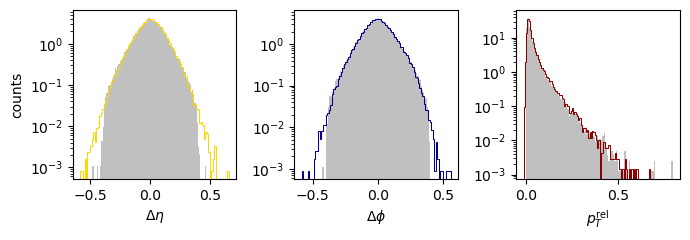

In [4]:
feature_plots(tops.particles, pipeline.target, save_dir=configs.workdir)

## Loading Pre-trained model

In [5]:
from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.datamodules.jetnet.datasets import JetNetDataset
from DynGenModels.datamodules.jetnet.dataloader import JetNetDataLoader
from DynGenModels.models.deep_sets import EPiC
from DynGenModels.dynamics.cnf.condflowmatch import SimplifiedCondFlowMatching

from DynGenModels.configs.jetnet_configs import JetNet_EPiC_CondFlowMatch as Configs

workdir = '../../results/JetNet.CondFlowMatch.EPiC.2023.10.09_23h54'
configs = Configs().load(workdir + '/config.json')
configs.workdir = workdir

tops = JetNetDataset(configs)
dataloader = JetNetDataLoader(tops, configs)
net = EPiC(configs)
dynamics = SimplifiedCondFlowMatching(net, configs)
cfm = DynGenModelTrainer(dynamics=dynamics, dataloader=dataloader, configs=configs)

cfm.load()

+--------------------+----------------------------------+
| Parameters         | Values                           |
+--------------------+----------------------------------+
| data_dir           | ../../data/jetnet                |
| data_name          | JetNet                           |
| features           | ['eta_rel', 'phi_rel', 'pt_rel'] |
| dim_input          | 3                                |
| num_particles      | 30                               |
| jet_types          | t                                |
| preprocess         | ['standardize']                  |
| device             | cpu                              |
| data_split_fracs   | [0.8, 0.2, 0.0]                  |
| batch_size         | 1024                             |
| epochs             | 10                               |
| lr                 | 0.001                            |
| early_stopping     |                                  |
| warmup_epochs      |                                  |
| print_epochs

In [6]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
from DynGenModels.datamodules.jetnet.dataprocess import PostProcessJetNetData 

pipeline = FlowMatchPipeline(trained_model=cfm, 
                             source_input=torch.randn(10000, 30, 3),
                             configs=configs, 
                             postprocessor=PostProcessJetNetData)

INFO: neural ODE solver with midpoint method and steps=100


/Users/dario/anaconda3/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


INFO: post-processing sampled data with ['inverse_standardize']


/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_79789/2651469408.py:25: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax_ratio.set_ylim(0.5, 1.5, 0) # Adjust this as needed
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_79789/2651469408.py:31: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(7)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_79789/2651469408.py:33: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(8)


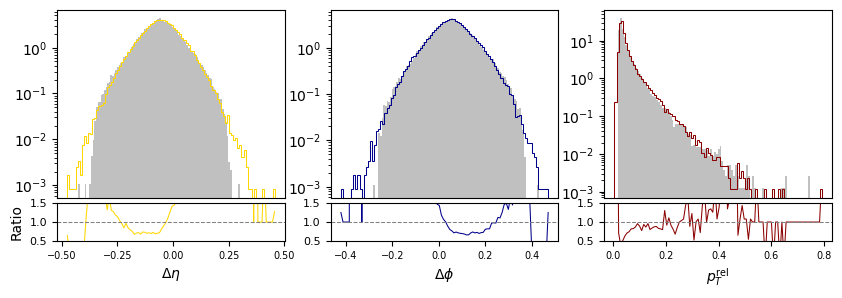

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def results_plots(jetnet_data, generated=None, save_dir=None, features=[r'$\Delta\eta$', r'$\Delta\phi$', r'$p^{\rm rel}_T$'], num_particles=100000):
    fig = plt.figure(figsize=(10, 3))
    gs = gridspec.GridSpec(2, 3, height_ratios=[5, 1])
    gs.update(hspace=0.05) 
    
    for idx, feature in enumerate(features):
        ax = fig.add_subplot(gs[idx])
        h1, bins, _ = ax.hist(jetnet_data[..., idx].flatten()[:num_particles], bins=100, log=True, color='silver', density=True)
        if generated is not None:
            h2, _, _ = ax.hist(generated[..., idx].flatten()[:num_particles], bins=100, log=True, color=['gold', 'darkblue', 'darkred'][idx], histtype='step', density=True, lw=0.75)
            ax.set_xticklabels([])
            ax.set_xticks([])
        else:
            ax.set_xlabel(feature)
        
        # Ratio plot
        if generated is not None:
            ax_ratio = fig.add_subplot(gs[idx + 3])
            ratio = np.divide(h1, h2, out=np.ones_like(h2), where=h2 != 0)
            ax_ratio.plot(0.5 * (bins[:-1] + bins[1:]), ratio, color=['gold', 'darkblue', 'darkred'][idx],lw=0.75)
            ax_ratio.set_ylim(0.5, 1.5, 0) # Adjust this as needed
            ax_ratio.set_xlabel(feature)
            #...horizontal dashed line at y=1
            ax_ratio.axhline(1, color='gray', linestyle='--', lw=0.75)
            #...set fontsize of tick numbers
            for tick in ax_ratio.xaxis.get_major_ticks():
               tick.label.set_fontsize(7)
            for tick in ax_ratio.yaxis.get_major_ticks():
              tick.label.set_fontsize(8)  
            if idx == 0:
                ax_ratio.set_ylabel('Ratio')
            ax_ratio.set_yticks([0.5, 1, 1.5])
    if save_dir is not None:
        plt.savefig(save_dir + '/particle_features.pdf')
    plt.show()

results_plots(tops.particles, pipeline.target, save_dir=configs.workdir)
    